# Basic demo for FASHN VTON v1.5

FASHN VTON v1.5: Efficient Maskless Virtual Try-On in Pixel Space

GitHub: https://github.com/fashn-AI/fashn-vton-1.5

## Installation

In [19]:
!git clone https://github.com/fashn-AI/fashn-vton-1.5
%cd fashn-vton-1.5

fatal: destination path 'fashn-vton-1.5' already exists and is not an empty directory.
/content/fashn-vton-1.5


In [20]:
!pip install .

Processing /content/fashn-vton-1.5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fashn-vton: filename=fashn_vton-1.5.0-py3-none-any.whl size=37601 sha256=51469fee236e58c8693d12b966826a872163b6f3c73677b353dac18555d59ace
  Stored in directory: /root/.cache/pip/wheels/83/85/d4/003a2789df48fea4fd69c5093b73b4495d75e045a364d41756
Successfully built fashn-vton
  Attempting uninstall: fashn-vton
    Found existing installation: fashn-vton 1.5.0
    Uninstalling fashn-vton-1.5.0:
      Successfully uninstalled fashn-vton-1.5.0


In [21]:
!python scripts/download_weights.py --weights-dir ./weights



model.safetensors: 100% 1.94G/1.94G [00:27<00:00, 71.1MB/s]
  Saved to: /content/fashn-vton-1.5/weights/model.safetensors

yolox_l.onnx: 100% 217M/217M [00:02<00:00, 85.6MB/s]
  Saved to: /content/fashn-vton-1.5/weights/dwpose/yolox_l.onnx
dw-ll_ucoco_384.onnx: 100% 134M/134M [00:01<00:00, 89.3MB/s]
  Saved to: /content/fashn-vton-1.5/weights/dwpose/dw-ll_ucoco_384.onnx

/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_p

## Functionality test

In [22]:
from IPython.display import display
from PIL import Image
from fashn_vton import TryOnPipeline
import matplotlib.pyplot as plt

In [23]:
# Initialize pipeline (automatically uses GPU if available)
pipeline = TryOnPipeline(weights_dir="./weights")

# Load images
person = Image.open("examples/data/model.webp").convert("RGB")
garment = Image.open("examples/data/garment.webp").convert("RGB")

TryOnPipeline - INFO - Using device: cuda
TryOnPipeline - INFO - Using dtype: torch.bfloat16
TryOnPipeline - INFO - Loading TryOnModel from /content/fashn-vton-1.5/weights/model.safetensors
TryOnPipeline - INFO - TryOnModel loaded
TryOnPipeline - INFO - Loading DWPose from /content/fashn-vton-1.5/weights/dwpose
TryOnPipeline - INFO - DWPose loaded
TryOnPipeline - INFO - Loading FashnHumanParser
TryOnPipeline - INFO - FashnHumanParser loaded


In [25]:
# Run inference
result = pipeline(
    person_image=person,
    garment_image=garment,
    category="tops",  # "tops" | "bottoms" | "one-pieces"
)

TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images


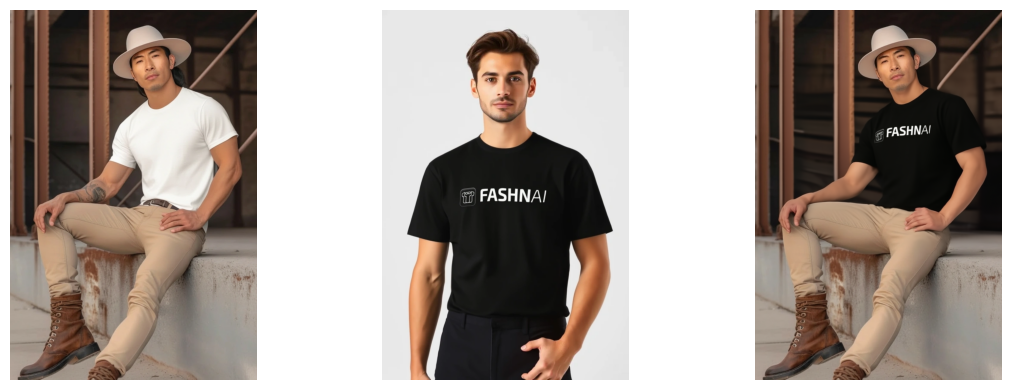

In [ ]:
imgs = [person, garment, result.images[0]]
plt.figure(figsize=(12, 4))
for i, img in enumerate(imgs, 1):
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Gradio Demo

In [ ]:
import gradio as gr
from PIL import Image
import torch

def run_vton(person_img, garment_img, category):
    person_img = Image.fromarray(person_img)
    garment_img = Image.fromarray(garment_img)
    result = pipeline(
        person_image=person_img,
        garment_image=garment_img,
        category=category,
    )
    return result.images[0]

demo = gr.Interface(
    fn=run_vton,
    inputs=[
        gr.Image(type="numpy", label="Person"),
        gr.Image(type="numpy", label="Garment"),
        gr.Radio(
            choices=["tops", "bottoms", "one-pieces"],
            value="tops",
            label="Category",
        ),
    ],
    outputs=gr.Image(type="pil", label="Result"),
    title="Virtual Try-On Demo",
    description="Upload a person image and a garment image to generate a try-on result.",
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://62ee617ca34303ab87.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Extending for multiple people

In [ ]:
import requests
from io import BytesIO

In [ ]:
url = "https://thumbs.dreamstime.com/b/full-length-portrait-group-young-men-wearing-jeans-looking-camera-smiling-35328409.jpg"

resp = requests.get(url, timeout=30)
resp.raise_for_status()

people = Image.open(BytesIO(resp.content)).convert("RGB")
people.save("examples/data/people.png")

In [ ]:
result = pipeline(
    person_image=people,
    garment_image=garment,
    category="tops",  # "tops" | "bottoms" | "one-pieces"
)

TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images


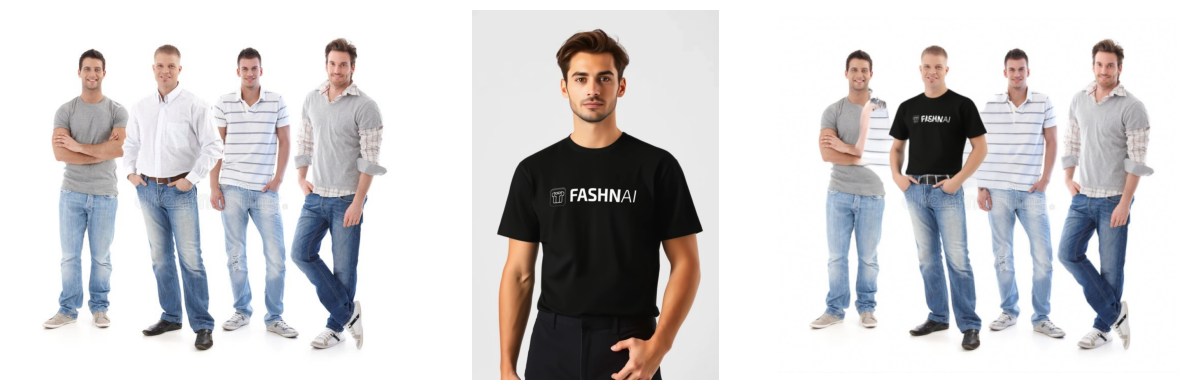

In [ ]:
imgs = [people, garment, result.images[0]]
plt.figure(figsize=(12, 4))
for i, img in enumerate(imgs, 1):
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Baseline approach

As you can see from the above result, attempting to run this model for multiple subjects leads to a glitched output.

A simple appraoch would be to segment the original image by the people, apply to each individual, and then re-combine. For the segementation, we will use Ultralytics YOLO https://github.com/ultralytics/ultralytics.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 83.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np

In [ ]:
# Load a model
model = YOLO("yolo26n-seg.pt")

# Predict with the model
results = model("examples/data/people.png")  # predict on an image


image 1/1 /content/fashn-vton-1.5/examples/data/people.png: 576x640 4 persons, 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


In [ ]:
def get_mask(result, H, W):
  cls_ids = result.boxes.cls.cpu().numpy().astype(int)  # (N,)
  person_idxs = cls_ids == 0
  person_polygons = [poly for poly, keep in zip(result.masks.xy, person_idxs) if keep]
  masks = []
  for poly in person_polygons:
      mask = np.zeros((H, W), dtype=np.uint8)
      poly_int = np.round(poly).astype(np.int32)
      cv2.fillPoly(mask, [poly_int], 1)
      masks.append(mask.astype(bool))
  return masks

In [ ]:
img_bgr = cv2.imread("examples/data/people.png")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]

masks = get_mask(results[0], H, W)

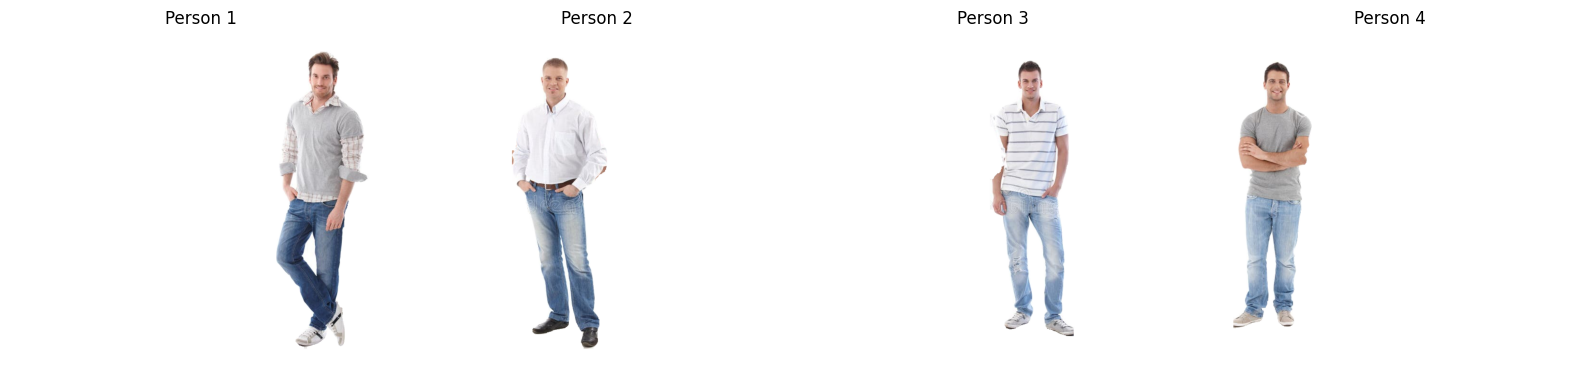

In [ ]:
img_bgr = cv2.imread("examples/data/people.png")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

people = []
for mask in masks:
    cutout = img.copy()
    cutout[~mask] = 255
    img_pil = Image.fromarray(cutout)
    people.append(img_pil)

# Plot side by side
plt.figure(figsize=(4 * len(people), 4))
for i, person in enumerate(people, 1):
    plt.subplot(1, len(people), i)
    plt.imshow(person)
    plt.title(f"Person {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
vton_people = []
for person in people:
  result = pipeline(
      person_image=person,
      garment_image=garment,
      category="tops",  # "tops" | "bottoms" | "one-pieces"
  )
  vton_people.append(result.images[0])

TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images
TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images
TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images
TryOnPipeline - INFO - Running inference with 30 timesteps...


Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

TryOnPipeline - INFO - Generated 1 images


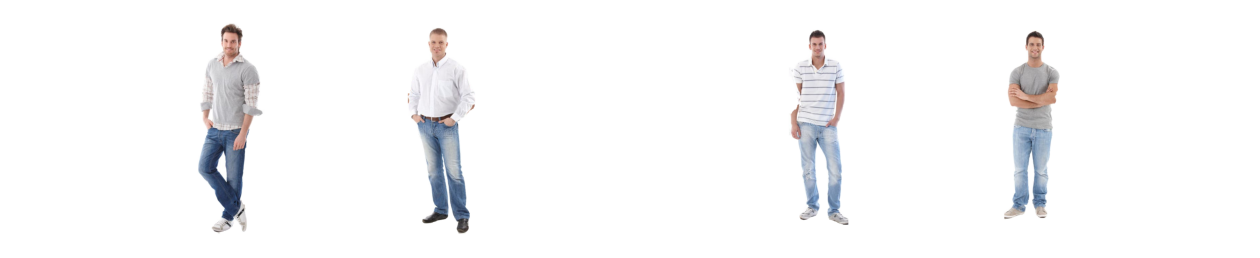

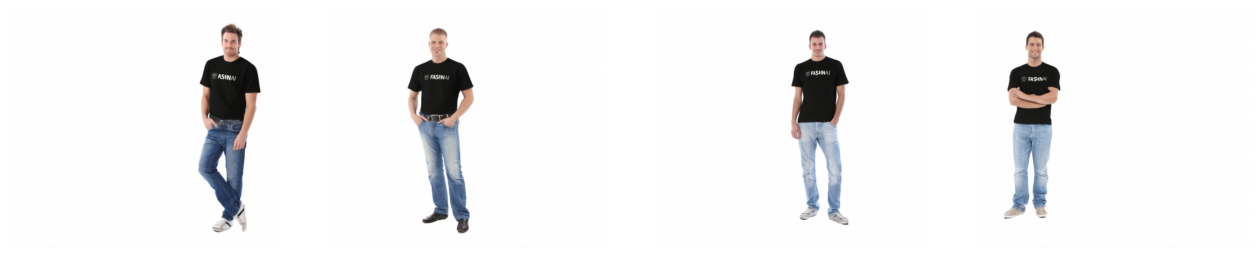

In [ ]:
plt.figure(figsize=(16, 8))
for i, person in enumerate(people, 1):
    plt.subplot(1, len(people), i)
    plt.imshow(person)
    plt.axis("off")
plt.figure(figsize=(16, 8))
for i, person in enumerate(vton_people, 1):
    plt.subplot(1, len(people), i)
    plt.imshow(person)
    plt.axis("off")

In [ ]:
vton_masks = []
for people in vton_people:
  W, H = people.size
  results = model(np.array(people))
  result = results[0]
  mask = get_mask(result, H, W)[0]
  vton_masks.append(mask)


0: 576x640 1 person, 14.7ms
Speed: 2.7ms preprocess, 14.7ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 person, 13.2ms
Speed: 2.5ms preprocess, 13.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 person, 13.0ms
Speed: 2.4ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 person, 1 frisbee, 13.9ms
Speed: 2.4ms preprocess, 13.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


In [ ]:
img_bgr = cv2.imread("examples/data/people.png")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, vton_people[0].size)

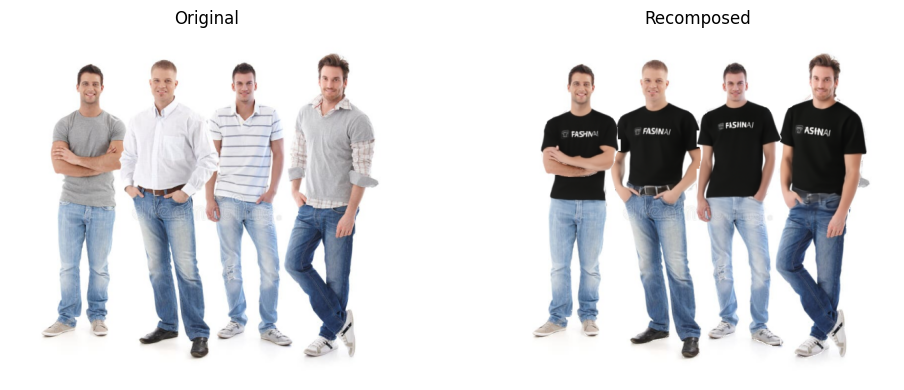

In [ ]:
# Start with a blank canvas (black background)
recomposed = img.copy()

for mask, vton_mask, img_pil in zip(masks, vton_masks, vton_people):
    recomposed[vton_mask] = np.array(img_pil)[vton_mask]

# Show side by side: original vs recomposed
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recomposed)
plt.title("Recomposed")
plt.axis("off")

plt.tight_layout()
plt.show()

Looks ok, but there are a lot of cropping artifacts, especially where the people cover each other. Another peoplem in composing the images is that the shape and size of the clothes now differs from the original image. With the 4th person, you can see part of his old sleeve.

Instead of doing each person separately, it could work better to do them 1 by one, and then fill it in.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def union_edges_mask(masks, edge_width=2):
    """
    masks: list of HxW boolean masks
    edge_width: thickness of edge in pixels
    returns: HxW boolean mask of unioned edges
    """
    if len(masks) == 0:
        raise ValueError("No masks provided")

    H, W = masks[0].shape
    edge_union = np.zeros((H, W), dtype=np.uint8)

    kernel = np.ones((edge_width * 2 + 1, edge_width * 2 + 1), np.uint8)

    for m in masks:
        m_u8 = (m.astype(np.uint8) * 255)

        # Extract edges via morphological gradient
        edges = cv2.morphologyEx(m_u8, cv2.MORPH_GRADIENT, kernel)

        edge_union = np.maximum(edge_union, edges)

    return edge_union.astype(bool)

In [ ]:
edges_mask = union_edges_mask(vton_masks, edge_width=2)
mask_pil = Image.fromarray((edges_mask.astype(np.uint8) * 255), mode="L")
image_pil = Image.fromarray(recomposed)
image_pil

/tmp/ipython-input-1160558915.py:2: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray((edges_mask.astype(np.uint8) * 255), mode="L")


# Inpaint to Remove Masking Artifacts

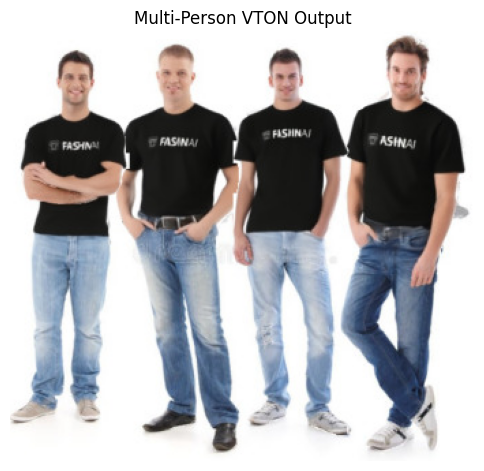

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image from the model
vton_img = Image.open("/content/multi_person_vton.png").convert("RGB")

plt.figure(figsize=(6,6))
plt.imshow(vton_img)
plt.title("Multi-Person VTON Output")
plt.axis("off")
plt.show()

In [2]:
# Completely reset and install stable versions
# Just added this as started getting errors later on so reinstalled everything so it will work
!pip uninstall -y transformers diffusers accelerate torch torchvision peft
!pip install transformers==4.36.2
!pip install diffusers==0.24.0
!pip install accelerate==0.24.1
!pip install torch==2.1.0 torchvision==0.16.0
!pip install opencv-python pillow matplotlib numpy

print("="*50)
print("All installs done, should be fixed now.")

Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Successfully uninstalled transformers-4.36.2
Found existing installation: diffusers 0.24.0
Uninstalling diffusers-0.24.0:
  Successfully uninstalled diffusers-0.24.0
  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fashn-human-parser 0.1.1 requires torch>=2.2, which is not installed.
fashn-vton 1.5.0 requires torch>=2.0.0, which is not installed.
fashn-vton 1.5.0 requires torchvision>=0.15.0, which is not installed.
sentence-transformers 5.2.3 requires torch>=1.11.0, which is not installed.
sentence-transformers 5.2.3 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.
  Using cached diffusers-0.24.0-py3-none-a

In [3]:
import torch
from diffusers import StableDiffusionInpaintPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load a Stable Diffusion inpainting model to clean the artifacts.
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)

/usr/local/lib/python3.12/dist-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/12 [00:00<?, ?it/s]

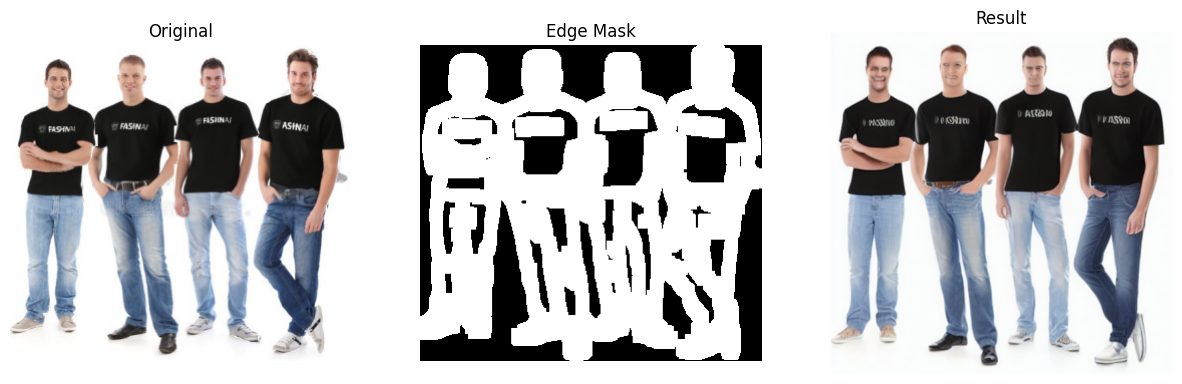

Complete, saved to /content/approach1_edge_inpainting.png


In [4]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Generate mask using edge detection
def generate_edge_mask(img):
    img_np = np.array(img)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    dilated = cv2.dilate(edges, np.ones((7,7), np.uint8), iterations=2)
    return Image.fromarray(dilated)

# Create mask
edge_mask = generate_edge_mask(vton_img)
mask_rgb = edge_mask.convert("RGB")
mask_np = np.array(mask_rgb)
mask_np[mask_np > 0] = 255
mask_cleaned = Image.fromarray(mask_np)

# Run inpainting
with torch.no_grad():
    cleaned = pipe(
        prompt="photo of people wearing realistic clothing, clean garment edges, natural lighting",
        negative_prompt="blurry, distorted, deformed body, artifacts",
        image=vton_img,
        mask_image=mask_cleaned,
        num_inference_steps=30,
        guidance_scale=6.0,
        strength=0.4
    ).images[0]

# Save result
cleaned.save("/content/approach1_edge_inpainting.png")

# Display
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(vton_img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask_cleaned, cmap='gray'); plt.title("Edge Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(cleaned); plt.title("Result"); plt.axis("off")
plt.show()
print("Complete, saved to /content/approach1_edge_inpainting.png")

Pipe available: True
Mask covers 100.00% of image


  0%|          | 0/15 [00:00<?, ?it/s]

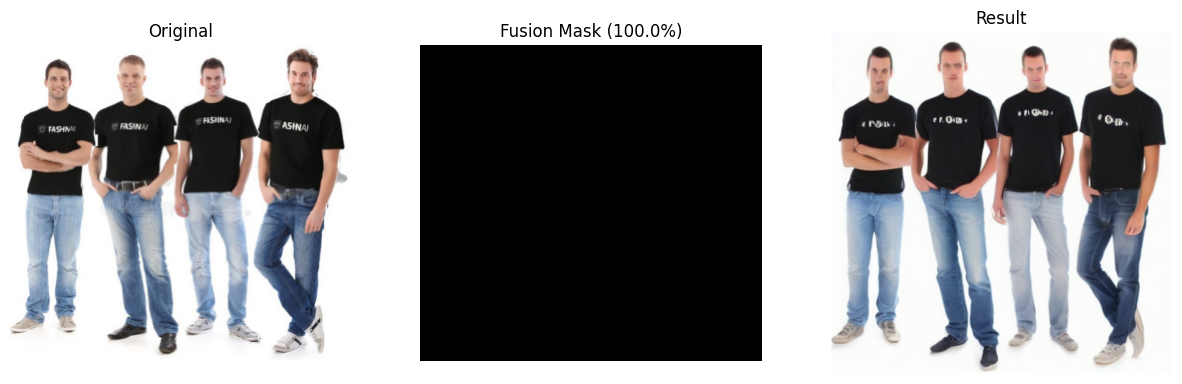

Complete


In [7]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Check if pipe exists
try:
    print(f"Pipe available: {pipe is not None}")
except NameError:
    print("ERROR: Run Notebook 2 first in this session!")
    # Don't proceed

def multi_detector_mask(img):
    img_np = np.array(img)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)

    # Edge detection
    edges = cv2.Canny(gray, 50, 150)

    # Color variance with safety checks
    l, a, b = cv2.split(lab)
    a = a.astype(np.float32)
    b = b.astype(np.float32)

    # Calculate variance safely
    a_blur = cv2.blur(a*a, (5,5))
    b_blur = cv2.blur(b*b, (5,5))
    var = np.sqrt(a_blur + b_blur + 1e-6)

    # Safe normalization
    if np.max(var) > np.min(var):
        var = ((var - np.min(var)) / (np.max(var) - np.min(var)) * 255).astype(np.uint8)
    else:
        var = np.zeros_like(var, dtype=np.uint8)

    # Saturation anomalies
    sat = hsv[:,:,1]
    _, sat_mask = cv2.threshold(sat, 200, 255, cv2.THRESH_BINARY)

    # Combine
    combined = cv2.bitwise_or(edges, var)
    combined = cv2.bitwise_or(combined, sat_mask)
    combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))

    # Remove small components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(combined, connectivity=8)
    min_area = 50
    cleaned = np.zeros_like(combined)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned[labels == i] = 255

    return Image.fromarray(cleaned)

# Create mask
fusion_mask = multi_detector_mask(vton_img)

# Convert to binary mask
mask_np = np.array(fusion_mask)
if len(mask_np.shape) == 3:
    mask_np = mask_np[:,:,0]
mask_np = (mask_np > 0).astype(np.uint8) * 255
mask_cleaned = Image.fromarray(mask_np).convert("RGB")

# Calculate mask coverage
coverage = np.sum(mask_np > 0) / mask_np.size * 100
print(f"Mask covers {coverage:.2f}% of image")

# Run inpainting
with torch.no_grad():
    cleaned = pipe(
        prompt="high quality photo, natural textures, realistic clothing, sharp details",
        negative_prompt="artifacts, blurry, distorted, low quality",
        image=vton_img,
        mask_image=mask_cleaned,
        num_inference_steps=30,
        guidance_scale=6.0,
        strength=0.5
    ).images[0]

cleaned.save("/content/approach2_fusion_inpainting.png")

# Display
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(vton_img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask_np, cmap='gray'); plt.title(f"Fusion Mask ({coverage:.1f}%)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(cleaned); plt.title("Result"); plt.axis("off")
plt.show()
print("Complete")

  0%|          | 0/11 [00:00<?, ?it/s]

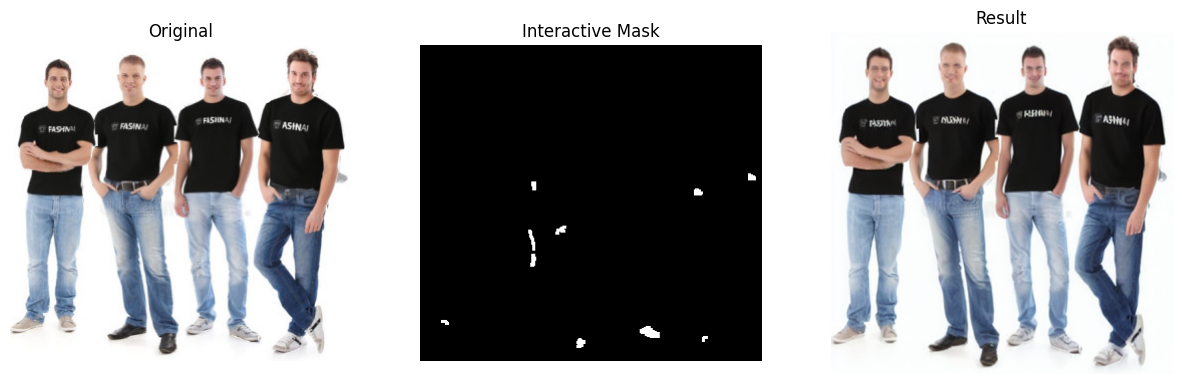

Complete, saved to /content/approach3_interactive_inpainting.png


In [8]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import torch

# This approach requires manual tuning
def create_interactive_mask(img, sat_thresh=40, val_low=80, val_high=200, area_min=30):
    img_np = np.array(img)
    hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)

    mask = (hsv[:,:,1] < sat_thresh) & (hsv[:,:,2] > val_low) & (hsv[:,:,2] < val_high)
    mask = mask.astype(np.uint8) * 255

    # Clean up
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Remove small components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    cleaned = np.zeros_like(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= area_min:
            cleaned[labels == i] = 255

    return Image.fromarray(cleaned)

# Use default values (you can modify these based on your image)
interactive_mask = create_interactive_mask(vton_img, sat_thresh=35, val_low=70, val_high=190, area_min=25)
mask_rgb = interactive_mask.convert("RGB")
mask_np = np.array(mask_rgb)
mask_np[mask_np > 0] = 255
mask_cleaned = Image.fromarray(mask_np)

with torch.no_grad():
    cleaned = pipe(
        prompt="fix small imperfections, smooth artifacts",
        negative_prompt="changing image, altering content",
        image=vton_img,
        mask_image=mask_cleaned,
        num_inference_steps=25,
        guidance_scale=6.0,
        strength=0.45
    ).images[0]

cleaned.save("/content/approach3_interactive_inpainting.png")

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(vton_img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask_cleaned, cmap='gray'); plt.title("Interactive Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(cleaned); plt.title("Result"); plt.axis("off")
plt.show()
print("Complete, saved to /content/approach3_interactive_inpainting.png")

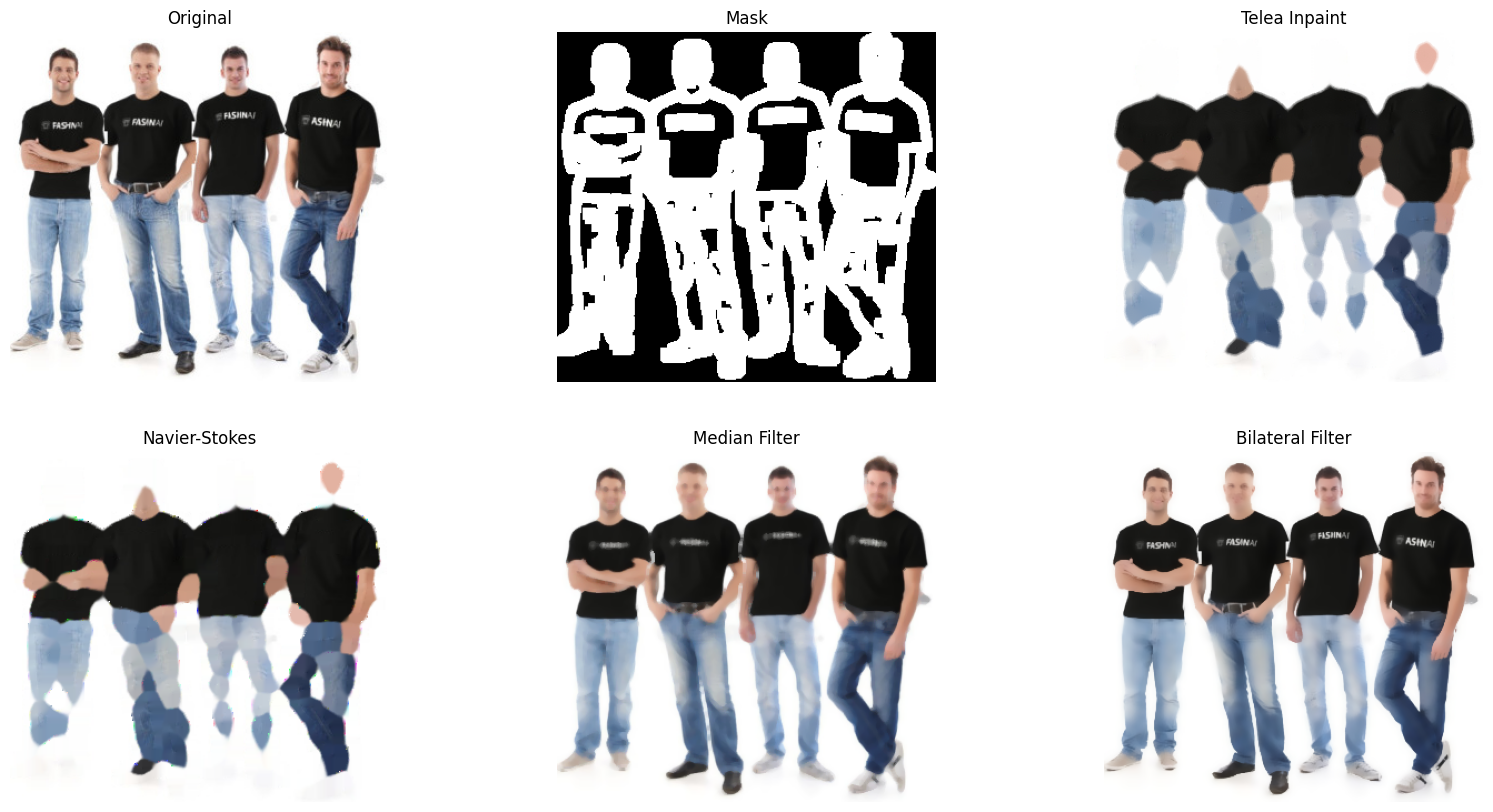

Complete, saved multiple OpenCV results


In [9]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pickle

original_np = np.array(vton_img)

# Create a simple mask (using edge detection as placeholder)
gray = cv2.cvtColor(original_np, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 50, 150)
mask = cv2.dilate(edges, np.ones((5,5), np.uint8), iterations=2)

# Method A: Telea inpainting
telea = cv2.inpaint(original_np, mask, 3, cv2.INPAINT_TELEA)

# Method B: Navier-Stokes inpainting
ns = cv2.inpaint(original_np, mask, 3, cv2.INPAINT_NS)

# Method C: Median filter
median = cv2.medianBlur(original_np, 5)

# Method D: Bilateral filter
bilateral = cv2.bilateralFilter(original_np, 9, 75, 75)

# Save all
Image.fromarray(telea).save("/content/approach4_telea.png")
Image.fromarray(ns).save("/content/approach4_navierstokes.png")
Image.fromarray(median).save("/content/approach4_median.png")
Image.fromarray(bilateral).save("/content/approach4_bilateral.png")

# Display
plt.figure(figsize=(20,10))
plt.subplot(2,3,1); plt.imshow(vton_img); plt.title("Original"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(mask, cmap='gray'); plt.title("Mask"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(telea); plt.title("Telea Inpaint"); plt.axis("off")
plt.subplot(2,3,4); plt.imshow(ns); plt.title("Navier-Stokes"); plt.axis("off")
plt.subplot(2,3,5); plt.imshow(median); plt.title("Median Filter"); plt.axis("off")
plt.subplot(2,3,6); plt.imshow(bilateral); plt.title("Bilateral Filter"); plt.axis("off")
plt.show()
print("Complete, saved multiple OpenCV results")

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

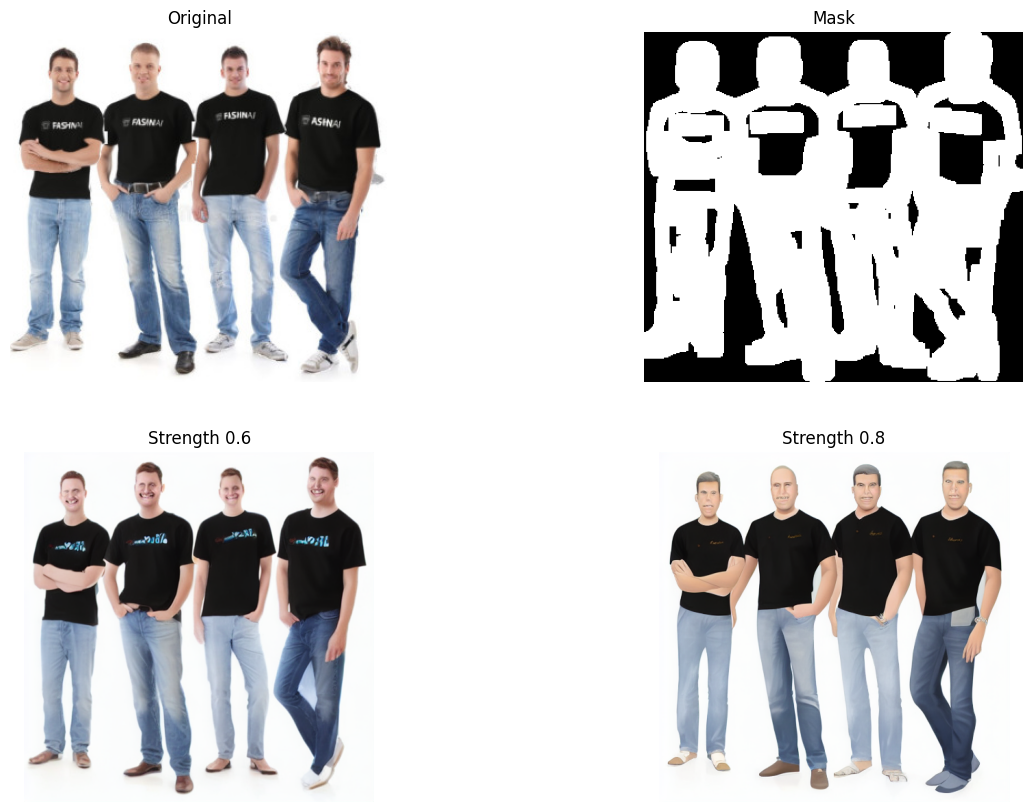

Complete, saved strength comparisons


In [10]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Simple mask - just use edge detection
gray = cv2.cvtColor(np.array(vton_img), cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 50, 150)
mask = cv2.dilate(edges, np.ones((5,5), np.uint8), iterations=3)
mask_image = Image.fromarray(mask).convert("RGB")

# Try with HIGH strength
with torch.no_grad():
    result_high = pipe(
        prompt="fix all artifacts completely, clean image",
        negative_prompt="artifacts, noise, blur",
        image=vton_img,
        mask_image=mask_image,
        num_inference_steps=40,
        guidance_scale=7.5,
        strength=0.8
    ).images[0]

# Try with MEDIUM strength
with torch.no_grad():
    result_medium = pipe(
        prompt="fix artifacts, clean image",
        negative_prompt="artifacts",
        image=vton_img,
        mask_image=mask_image,
        num_inference_steps=30,
        guidance_scale=6.5,
        strength=0.6
    ).images[0]

result_high.save("/content/approach5_high_strength.png")
result_medium.save("/content/approach5_medium_strength.png")

plt.figure(figsize=(15,10))
plt.subplot(2,2,1); plt.imshow(vton_img); plt.title("Original"); plt.axis("off")
plt.subplot(2,2,2); plt.imshow(mask, cmap='gray'); plt.title("Mask"); plt.axis("off")
plt.subplot(2,2,3); plt.imshow(result_medium); plt.title("Strength 0.6"); plt.axis("off")
plt.subplot(2,2,4); plt.imshow(result_high); plt.title("Strength 0.8"); plt.axis("off")
plt.show()
print("Complete, saved strength comparisons")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

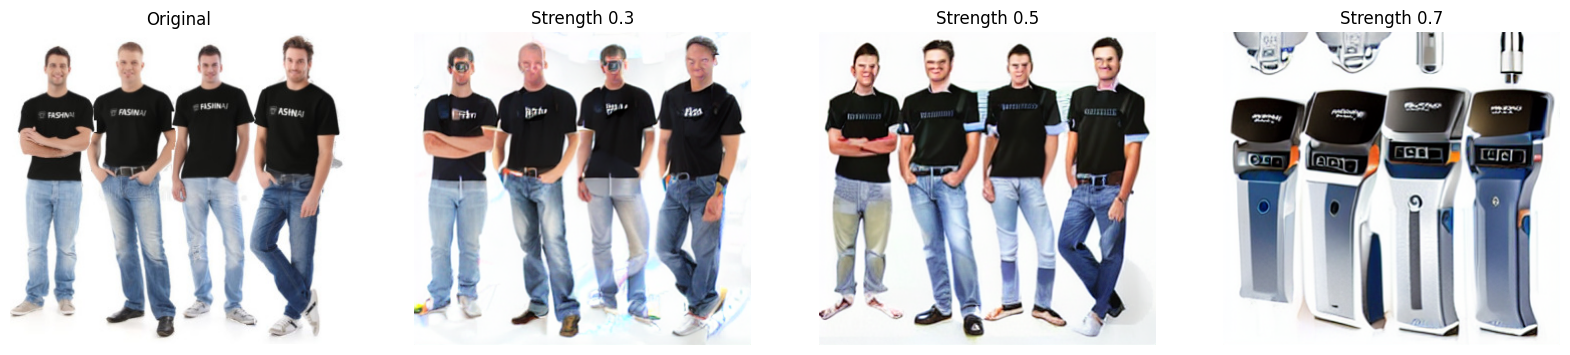

Complete - saved img2img results


In [11]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load img2img pipeline
pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)

# Run with different strengths
results = []
strengths = [0.3, 0.5, 0.7]

for i, strength in enumerate(strengths):
    with torch.no_grad():
        result = pipe_img2img(
            prompt="high quality photo, clean image, sharp details",
            negative_prompt="artifacts, noise, blur, low quality",
            image=vton_img,
            strength=strength,
            num_inference_steps=30,
            guidance_scale=7.0
        ).images[0]
    results.append(result)
    result.save(f"/content/approach6_img2img_strength_{strength}.png")

# Display
plt.figure(figsize=(20,5))
plt.subplot(1,4,1); plt.imshow(vton_img); plt.title("Original"); plt.axis("off")
for i, (strength, result) in enumerate(zip(strengths, results)):
    plt.subplot(1,4,i+2); plt.imshow(result); plt.title(f"Strength {strength}"); plt.axis("off")
plt.show()
print("Complete - saved img2img results")

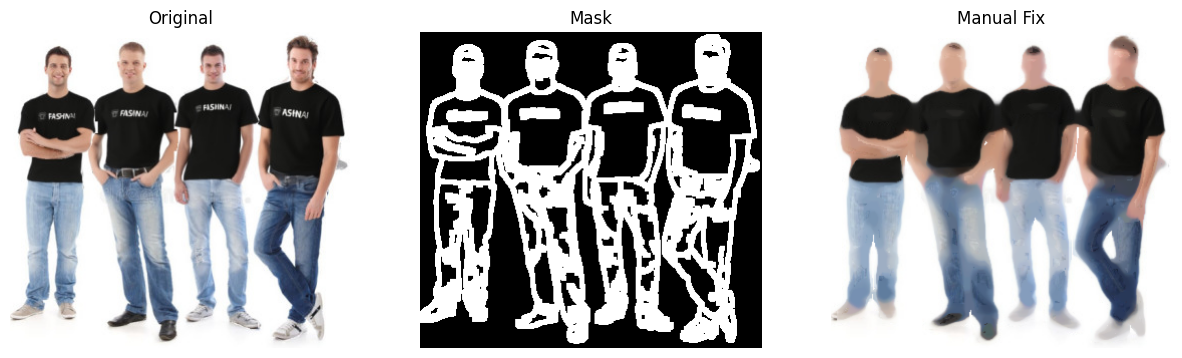

Complete, saved manual replacement


In [12]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pickle

original_np = np.array(vton_img)
h, w = original_np.shape[:2]

# Create a simple edge mask
gray = cv2.cvtColor(original_np, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 50, 150)
mask = cv2.dilate(edges, np.ones((3,3), np.uint8), iterations=2)

# Manual pixel replacement
fixed = original_np.copy()
mask_y, mask_x = np.where(mask > 0)

for y, x in zip(mask_y, mask_x):
    if y > 5 and y < h-5 and x > 5 and x < w-5:
        # Sample from neighborhood
        neighborhood = fixed[y-5:y+6, x-5:x+6]
        if neighborhood.size > 0:
            # Use median of neighborhood
            fixed[y, x] = np.median(neighborhood.reshape(-1, 3), axis=0)

# Apply light smoothing
blurred = cv2.GaussianBlur(fixed, (3,3), 0.5)
mask_soft = mask.astype(np.float32) / 255.0
mask_soft = cv2.GaussianBlur(mask_soft, (3,3), 1)
mask_soft_3ch = np.stack([mask_soft, mask_soft, mask_soft], axis=2)
final = fixed * (1 - mask_soft_3ch) + blurred * mask_soft_3ch
final = np.clip(final, 0, 255).astype(np.uint8)

Image.fromarray(final).save("/content/approach7_manual_replacement.png")

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(original_np); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.title("Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(final); plt.title("Manual Fix"); plt.axis("off")
plt.show()
print("Complete, saved manual replacement")
